In [1]:
# import libraries
import numpy as np
import pandas as pd

# seaborn is for making plots
import seaborn as sns
import matplotlib.pyplot as plt
import regex
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# These are all the imports needed for the assignment
%matplotlib inline

#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

## Linear Regression

In [2]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

- "C:/Users/19495/Downloads/amazon_reviews_us_Toys_v1_00.tsv.gz"

- names = columns because this allows is to focus on only the attributes we care about

- sep = '\t' since this is a tsv file, this informs program to separate based on tabs, not commas

- check that on_bad_lines arg is not removing valid things!

- **take out first line! because there is a restatement of the column names so string**

In [3]:
# initializing empty dataframes for testing and training data
training_data = pd.DataFrame()
testing_data = pd.DataFrame()
# on_bad_lines = 'skip' does not seem to work
one_file = pd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", names =  columns, sep = '\t').iloc[1:,:]

In [4]:
one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [5]:
one_file.shape

(3091103, 15)

In [6]:
one_file.isnull().sum().sort_values(ascending = False)

review_body          88
review_headline      31
review_date          24
product_title         4
verified_purchase     0
vine                  0
total_votes           0
helpful_votes         0
star_rating           0
product_category      0
product_parent        0
product_id            0
review_id             0
customer_id           0
marketplace           0
dtype: int64

In [7]:
one_file.dropna(inplace=True)
one_file.isnull().sum().sort_values(ascending = False)

review_date          0
review_body          0
review_headline      0
verified_purchase    0
vine                 0
total_votes          0
helpful_votes        0
star_rating          0
product_category     0
product_title        0
product_parent       0
product_id           0
review_id            0
customer_id          0
marketplace          0
dtype: int64

In [8]:
#convert all mixed datatypes --> string objects (unable to convert to int)
one_file['customer_id'] = one_file['customer_id'].apply(int) #1
one_file['product_parent'] = one_file['product_parent'].apply(int) #4
one_file['star_rating'] = one_file['star_rating'].apply(int) #7
one_file['helpful_votes'] = one_file['helpful_votes'].apply(int) #8
one_file['total_votes'] = one_file['total_votes'].apply(int) #9

In [9]:
one_file['star_rating'].value_counts()

5    1779347
4     536400
1     357802
3     238382
2     179025
Name: star_rating, dtype: int64

General Notes
- to remove certain column values, run smthg like one_file[one_file["star_rating"] != 3]

In [10]:
# df w/ ratings of 3 removed for sentiment analysis
rem_file = one_file[one_file['star_rating'] != 3]
# if rating greater than 3 --> 1, if lower --> 0
rem_file['positively_rated'] = np.where(rem_file['star_rating'] > 3, 1, 0)

In [11]:
rem_file['positively_rated'].value_counts()

1    2315747
0     536827
Name: positively_rated, dtype: int64

In [12]:
rem_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,positively_rated
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31,1
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31,1
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31,1
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31,0
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31,1


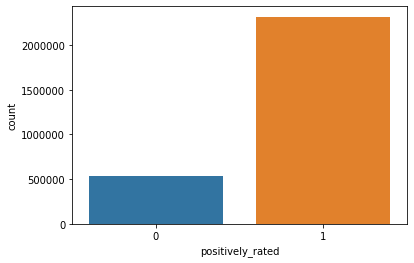

In [13]:
sns.countplot(rem_file['positively_rated'])

- 'review_body' is the independent variable, while 'positively_rated' is the dependent variable

In [14]:
x_train, x_test, y_train, y_test = train_test_split(rem_file['review_body'], rem_file['positively_rated'], 
                                                    random_state = 50)

In [15]:
print(x_train)

1539775    Flimsy construction and poor sound range vs so...
2504431    Product did not work. I hooked up both ends. O...
3070343    I purchased both the ZHDTV and the ...RCA ampl...
1250047    UPDATE!!!<br />The team at Mpow really stand b...
1905213    No complaints; these are perfect!  I wish they...
                                 ...                        
2747483    This may be the most rugged CD/DVD storage pos...
729500     It works great. I was having problems getting ...
2526170    This shelving unit was easy to put together an...
1241297                       Great product at a great price
2139970    Searched the net for several weeks before deci...
Name: review_body, Length: 2139430, dtype: object


- the .get_feature_names() will give us the # of diff terms! Features w/ low tf-idf scores are either very common across all reviews or rarely used. High tf-idf features are highly used in specific reviews, but rarely used in all docs

In [16]:
vect = TfidfVectorizer().fit(x_train)
len(vect.get_feature_names())

308301

In [17]:
x_train_vectorized = vect.transform(x_train)

In [18]:
# This is model fitting. Once it's done, we can make predictions
model = LogisticRegression()
model.fit(x_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
predictions = model.predict(vect.transform(x_test))
print(predictions)

[1 0 1 ... 1 1 1]


In [20]:
# Compute AUC score
print("AUC:", roc_auc_score(y_test, predictions))

AUC: 0.8844488688126042


In [21]:
# Look at which sentiments have the smallest and largest tf-idf score
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

- The Smallest Coef words either appear across all reviews, or only really in long reviews
- The Largest Coef words appear frequently in a review but did not appear commonly across all reviews

In [22]:
print("Smallest Coef", feature_names[sorted_coef_index[:10]])

Smallest Coef ['not' 'unacceptable' 'poor' 'worst' 'useless' 'returning' 'terrible'
 'disappointing' 'worthless' 'stopped']


In [23]:
print("Largest Coef", feature_names[sorted_coef_index[:-11:-1]])

Largest Coef ['great' 'love' 'perfect' 'excellent' 'perfectly' 'amazing' 'awesome'
 'highly' 'best' 'easy']


## Experimentation
- Try fiddling with, and cleaning the different features if possible
- Try removing one word reviews, and see the difference in accuracy (try on Suki's KNN)

In [39]:
# verified_purchase, star_rating, helpful_votes, total_votes, rev_title_comp, neg_prop, neu_prop, pos_prop
# Accuracy went down with addition of compound prop, maybe overfitting?
# prod_title_comp
# Run sentiment analysis
# marketplace --> using alphabet to convert to numbers
# helpful votes proportion --> get rid of total_votes

In [40]:
# try removing one word reviews and see the diff
# try it on suki's knn

## Data Sampling

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [107]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', \
           'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
elec_df = pd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", names =  columns, sep = '\t').iloc[1:,:]

In [108]:
#try_df = elec_df[elec_df['customer_id'] == 2462611]
try_df = elec_df.iloc[[2462611]]
try_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2462612,US,12340766,R2RYU79O2TFNO1,B0038W0K2K,952833522,MEElectronics Sport-Fi M6 Noise Isolating In-Ear Headphones with Memory Wire,Electronics,3,0,0,N,Y,need better wrap arounds for ears,the sound is excellent however the wrap around the ear is not the best. If exercising i had to adjust the ear pieces a few times.,2012-01-05


In [112]:
elec_df = elec_df[: 600_000]
elec_df.shape

(600000, 15)

In [113]:
def df_sampling(df):
    # Since we know that there are more unverified than verified --> we sample based on that
    
    # Since there are no data values in 'verified_purchase' columns that deviate from 'Y' or 'N' we proceed
    verified_count_df = df[df['verified_purchase'] == 'Y']
    unverified_count_df = df[df['verified_purchase'] == 'N']
    
    print("Number of verified purchases:", len(verified_count_df))
    print("Number of unverified purchases:", len(unverified_count_df))
    
    sample_len = len(unverified_count_df)
    
    verified_sample_df = verified_count_df.sample(n = sample_len)
    unified_df = pd.concat([unverified_count_df, verified_sample_df])
    
    print("Number of verified purchases (balanced dataset):", len(unified_df[unified_df['verified_purchase'] == 'Y']))
    print("Number of unverified purchases (balanced dataset):", len(unified_df[unified_df['verified_purchase'] == 'N']))
    
    return unified_df

In [114]:
balanced_elec = df_sampling(elec_df)
display(balanced_elec.head())

Number of verified purchases: 555259
Number of unverified purchases: 44741
Number of verified purchases (balanced dataset): 44741
Number of unverified purchases (balanced dataset): 44741


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
21,US,42944532,R1OD3VMIZCCADZ,B012VIWG28,676077256,Brainwavz Hengja - The Headphone Desk Hanger,Electronics,5,0,0,N,N,"Simple hanger; clamp is strong, with a pad; hanger swivels to accommodate many possible attachment locations","Can't get any simpler that this. And it works just about anywhere you can find a flat lip or side panel. Ideally the lip should be at least 1 3/8&#34; for best stability, but I got it to hold decently well on the short lip of my desk top, which is just 3/4&#34;.<br /><br />Because the front hanger piece can be adjusted to hang parallel or perpendicular, (or any angle in between), to the clamping surface, I was able to get the firmest grip on the side of a bookcase. My best idea, and where I use it now, is attached to the arm of my executive style office chair, near where it meets the chair back. I don't knock it with my arm or elbow as I raise/lower/turn in my chair. It is really a nifty place to stow the headphones--within easy reach, but not a cumbersome location either.<br /><br />It is well-constructed with good layer of powder coating on the metal. Hardware looks to be top quality, too.<br /><br />*I received a sample product from Brainwavz.",2015-08-31
52,US,143935,R3GWX8AYXWO5ZE,B00GHQMZ7W,318981354,Brookstone - SoundShield Noise Cancelling Stereo Headphones,Electronics,4,0,0,N,N,... and being an active traveler they have held up pretty well. Comfortable for long flights and still have ...,Bought these a year ago and being an active traveler they have held up pretty well. Comfortable for long flights and still have 100% noise cancellation,2015-08-31
56,US,11990894,R2MXU8IVR1Q1S5,B00SQ94K7Q,783049725,"SOUNDXL Blackout C-Series Bluetooth Wireless Waterproof Speaker for iPhones, Android, Tablets, Smartphones and MP3 Speaker",Electronics,5,1,1,N,N,Perfect gift for everyone on your list or treat yourself! Great quality!,Enjoy crystal clear clarity sound with this product! Super great quality! Highly recommended! Would make a perfect gift for anyone or for yourself!!,2015-08-31
58,US,7063270,R3QLZUL02LTP06,B00MRUX9IG,684454145,"Comply Foam Premium Earphone Tips - Isolation T-100 (Multi-Color, 3-Pairs, Large)",Electronics,2,0,0,N,N,Happy For about 4 weeks using these in the gym,Happy For about 4 weeks using these in the gym. The tips then lost the sponginess and then teared over time. I kept my headphones in a case and yet they wear out when you use them after a few weeks.,2015-08-31
62,US,33972520,R99E5GE71NOWK,B00XVQ0PCS,220816069,"iDeaUSA Wireless Speaker, Bluetooth 4.0 Bass Speaker, Subwoofer and Boombox Outdoor Speaker, with Mic for Hands Free Calling, NFC Supported for IOS and Android Smartphone and Tablet (Black&Red)",Electronics,5,0,0,N,N,Wonderful for bicycles,Our family loves to go bike riding but i get bored after a while. I got a free trial of these Taco speakers and took them along one time when i rode for a while. Put on my favorite jam and jammed out to the amazing music.,2015-08-31


## Data Cleaning
- Referenced from code in https://monkeylearn.com/blog/text-cleaning/ and https://www.kaggle.com/code/ragnisah/text-data-cleaning-tweets-analysis/notebook

In [8]:
# Import re for text cleaning purposes
import re

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
def df_cleaning(df, col):
    # Drop rows with na values
    df.dropna(inplace = True)
    
    new_col_name = "new_" + col
    df[new_col_name] = df[col].copy()
    
    # Remove unwanted formatting characters
    format_strs = dict.fromkeys(['<br /><br />', '&#34', 'br', '&quot', '<br />'], ' ')
    for key in format_strs:
        df[new_col_name] = df[new_col_name].apply(lambda review: review.replace(key, format_strs[key]))
    # removing quotes produces smthg like this --> 'The product has great ;sound; --> we must remove punctuation

    # Case normalization (lower case)
    df[new_col_name] = df[new_col_name].str.lower()
    
    # Removing numbers
    remove_num_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_num_dict.items():
        df[new_col_name] = df[new_col_name].apply(
            lambda x: x.replace(key, val))
    
    # Remove stopwords
    stop_lst = stopwords.words('english')
    # ****Do we not have to take stopwords out BEFORE removing punctuation? Otherwise words with punct like “cant” remains there
    df[new_col_name] = df[new_col_name].apply(lambda text_body: " ".join([word for word in text_body.split() if word not in (stop_lst)]))
    
    # Removing Unicode Chars (punctuation, URL, @)
    df[new_col_name] = df[new_col_name].apply(lambda rev: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", rev))
    
    # Lemmatization
    word_lemmatizer = WordNetLemmatizer()
    df[new_col_name] = df[new_col_name].apply(lambda txt: " ".join([(word_lemmatizer.lemmatize(word)) for word in txt.split()]))
    
    return df

In [10]:
'''
def df_cleaning(df, col):
    # Drop rows with na values
    df.dropna(inplace = True)
    
    df['new_review_body'] = df['review_body'].copy()
    
    # Remove unwanted formatting characters
    format_strs = dict.fromkeys(['<br /><br />', '&#34', 'br', '&quot', '<br />'], ' ')
    for key in format_strs:
        df['new_review_body'] = df['new_review_body'].apply(lambda review: review.replace(key, format_strs[key]))
    # removing quotes produces smthg like this --> 'The product has great ;sound; --> we must remove punctuation

    # Case normalization (lower case)
    df['new_review_body'] = df['new_review_body'].str.lower()
    
    # Removing numbers
    remove_num_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_num_dict.items():
        df['new_review_body'] = df['new_review_body'].apply(
            lambda x: x.replace(key, val))
    
    # Remove stopwords
    stop_lst = stopwords.words('english')
    stop_lst += (["can't", "i'm" "i'd", "i've", "i'll", "that's", "there's", "they're"])
    # ****Do we not have to take stopwords out BEFORE removing punctuation? Otherwise words with punct like “cant” remains there
    df['new_review_body'] = df['new_review_body'].apply(lambda text_body: " ".join([word for word in text_body.split() if word not in (stop_lst)]))
    
    # Removing Unicode Chars (punctuation, URL, @)
    df['new_review_body'] = df['new_review_body'].apply(lambda rev: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", rev))
    
    # Lemmatization
    word_lemmatizer = WordNetLemmatizer()
    df['new_review_body'] = df['new_review_body'].apply(lambda txt: " ".join([(word_lemmatizer.lemmatize(word)) for word in txt.split()]))
    
    return df
'''

'\ndef df_cleaning(df, col):\n    # Drop rows with na values\n    df.dropna(inplace = True)\n    \n    df[\'new_review_body\'] = df[\'review_body\'].copy()\n    \n    # Remove unwanted formatting characters\n    format_strs = dict.fromkeys([\'<br /><br />\', \'&#34\', \'br\', \'&quot\', \'<br />\'], \' \')\n    for key in format_strs:\n        df[\'new_review_body\'] = df[\'new_review_body\'].apply(lambda review: review.replace(key, format_strs[key]))\n    # removing quotes produces smthg like this --> \'The product has great ;sound; --> we must remove punctuation\n\n    # Case normalization (lower case)\n    df[\'new_review_body\'] = df[\'new_review_body\'].str.lower()\n    \n    # Removing numbers\n    remove_num_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",\n                   "(": "", ")":""}\n    for key, val in remove_num_dict.items():\n        df[\'new_review_body\'] = df[\'new_review_body\'].apply(\n            lambda x: x.rep

### Esther's Data Cleaning

In [116]:
# Pre-processing Text Reviews
def data_cleaning(df):
    # Removing emtpy cells
    df.dropna(inplace=True)
    df['review_body_cleaned'] = df['review_body'].copy()
    
    # Removing Unicode Chars (URL)
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda rev: re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", rev))
        
    # Replace HTML keywords with blank space ("&quot;", "br", "&#34")
    remove_dict = {"<br /><br />": " ", "<br />": " ", "br ": "", "&quot;": " ", "&#34": " ",
                   "<BR>": " ", "_": ""}
    for key, val in remove_dict.items():
        df['review_body_cleaned'] = df['review_body_cleaned'].apply(
            lambda x: x.replace(key, val))
        
    print("\n######## Remove URL and HTML Keywords Complete ########")
    
    # Remove Punctuations and numbers
    tokenizer = RegexpTokenizer(r'\w+')
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda x: ' '.join([word for word in tokenizer.tokenize(x)]))
    
    remove_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_dict.items():
        df['review_body_cleaned'] = df['review_body_cleaned'].apply(
            lambda x: x.replace(key, val))
    
    print("\n######## Remove Punctuation and Numbers Complete ########")
    
    # Lowercase Words
    df['review_body_cleaned'] = df['review_body_cleaned'].str.lower()
    
    print("\n######## Lowercase Complete ########")

    # Remove Stop Words.
    stop = stopwords.words('english')
      
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda x: ' '.join([word for word in x.split() if word.strip() not in stop]))
    
    print("\n######## Remove Stop Words Complete ########")
    
    # Lemmatization using .lemma_
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    
    print("\n######## Data Cleaning Complete ########")
    
    return df

In [12]:
text = "http://localhost:8891/notebooks/FARS/DataTest%20(3).ipynb"
re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", text)
#re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
#@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|

''

- Review 2462611 is overall negative, but getting a positive compound score
- One thing to note is that words like "didnt" are falling through
- Thus tried removing stopwords before removing unicode chars --> if you look to the Sentiment Analysis, the compound score of review 2462611 is actually almost the same. Not much difference, but wondering the overall accuracy
- Maybe also take care of words like LOL or lmao --> How to? These are evaluated as positive

In [117]:
# Get a subset of only the most relevant columns, and clean the df
balanced_elec = balanced_elec[['marketplace', 'star_rating', 'helpful_votes', 'total_votes', \
                               'review_headline', 'verified_purchase', 'review_body']]

cleaned_elec = df_cleaning(balanced_elec, 'review_body')
cleaned_elec = df_cleaning(balanced_elec, 'review_headline')
cleaned_elec.head()

,marketplace,star_rating,helpful_votes,total_votes,review_headline,verified_purchase,review_body,new_review_body,new_review_headline
21,US,5,0,0,"Simple hanger; clamp is strong, with a pad; hanger swivels to accommodate many possible attachment locations",N,"Can't get any simpler that this. And it works just about anywhere you can find a flat lip or side panel. Ideally the lip should be at least 1 3/8&#34; for best stability, but I got it to hold decently well on the short lip of my desk top, which is just 3/4&#34;.<br /><br />Because the front hanger piece can be adjusted to hang parallel or perpendicular, (or any angle in between), to the clamping surface, I was able to get the firmest grip on the side of a bookcase. My best idea, and where I use it now, is attached to the arm of my executive style office chair, near where it meets the chair back. I don't knock it with my arm or elbow as I raise/lower/turn in my chair. It is really a nifty place to stow the headphones--within easy reach, but not a cumbersome location either.<br /><br />It is well-constructed with good layer of powder coating on the metal. Hardware looks to be top quality, too.<br /><br />*I received a sample product from Brainwavz.",cant get simpler this work anywhere find flat lip side panel ideally lip least best stability got hold decently well short lip desk top front hanger piece adjusted hang parallel perpendicular angle between clamping surface able get firmest grip side bookcase best idea use now attached arm executive style office chair near meet chair back knock arm elbow raiselowerturn chair really nifty place stow headphoneswithin easy reach cumbersome location either wellconstructed good layer powder coating metal hardware look top quality too i received sample product brainwavz,simple hanger clamp strong pad hanger swivel accommodate many possible attachment location
52,US,4,0,0,... and being an active traveler they have held up pretty well. Comfortable for long flights and still have ...,N,Bought these a year ago and being an active traveler they have held up pretty well. Comfortable for long flights and still have 100% noise cancellation,bought year ago active traveler held pretty well comfortable long flight still noise cancellation,active traveler held pretty well comfortable long flight still
56,US,5,1,1,Perfect gift for everyone on your list or treat yourself! Great quality!,N,Enjoy crystal clear clarity sound with this product! Super great quality! Highly recommended! Would make a perfect gift for anyone or for yourself!!,enjoy crystal clear clarity sound product super great quality highly recommended would make perfect gift anyone yourself,perfect gift everyone list treat yourself great quality
58,US,2,0,0,Happy For about 4 weeks using these in the gym,N,Happy For about 4 weeks using these in the gym. The tips then lost the sponginess and then teared over time. I kept my headphones in a case and yet they wear out when you use them after a few weeks.,happy week using gym tip lost sponginess teared time kept headphone case yet wear use week,happy week using gym
62,US,5,0,0,Wonderful for bicycles,N,Our family loves to go bike riding but i get bored after a while. I got a free trial of these Taco speakers and took them along one time when i rode for a while. Put on my favorite jam and jammed out to the amazing music.,family love go bike riding get bored while got free trial taco speaker took along one time rode while put favorite jam jammed amazing music,wonderful bicycle


In [118]:
# After cleaning both the review body and headline, remove the original cols for both
cleaned_elec = cleaned_elec[['marketplace', 'star_rating', 'helpful_votes', 'total_votes', \
                             'new_review_headline', 'new_review_body', 'verified_purchase']]
cleaned_elec.head()

,marketplace,star_rating,helpful_votes,total_votes,new_review_headline,new_review_body,verified_purchase
21,US,5,0,0,simple hanger clamp strong pad hanger swivel accommodate many possible attachment location,cant get simpler this work anywhere find flat lip side panel ideally lip least best stability got hold decently well short lip desk top front hanger piece adjusted hang parallel perpendicular angle between clamping surface able get firmest grip side bookcase best idea use now attached arm executive style office chair near meet chair back knock arm elbow raiselowerturn chair really nifty place stow headphoneswithin easy reach cumbersome location either wellconstructed good layer powder coating metal hardware look top quality too i received sample product brainwavz,N
52,US,4,0,0,active traveler held pretty well comfortable long flight still,bought year ago active traveler held pretty well comfortable long flight still noise cancellation,N
56,US,5,1,1,perfect gift everyone list treat yourself great quality,enjoy crystal clear clarity sound product super great quality highly recommended would make perfect gift anyone yourself,N
58,US,2,0,0,happy week using gym,happy week using gym tip lost sponginess teared time kept headphone case yet wear use week,N
62,US,5,0,0,wonderful bicycle,family love go bike riding get bored while got free trial taco speaker took along one time rode while put favorite jam jammed amazing music,N


In [119]:
# Convert all mixed datatypes --> string objects (unable to convert to int)
cleaned_elec['star_rating'] = cleaned_elec['star_rating'].apply(int) #7
cleaned_elec['helpful_votes'] = cleaned_elec['helpful_votes'].apply(int) #8
cleaned_elec['total_votes'] = cleaned_elec['total_votes'].apply(int) #9

In [120]:
type(cleaned_elec['star_rating'][21])

numpy.int64

## Possible Approaches
- Since linear regression only works for predicting a binary dependent variable, try naive bayes or random forest?
- What if we used the max percentage (of good, bad, neutral percentage) to use linear regression to try and predict verified or non-verified? OR use multiple features and use KNN or some other method

## Vader Sentiment Analysis

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [20]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(review):
    # Return a dict with the keys: neg, neu, pos, compound with their respective proportions
    sentiment_df = analyzer.polarity_scores(review)
    return sentiment_df

In [174]:
ex_dict = get_sentiment_scores(cleaned_elec[['new_review_body']].iloc[0][0])
print("Example of sentiment proportions of the first review:", ex_dict)
(ex_dict.pop('compound'))
#ex_dict.index(max(list(ex_dict.values())))
list(ex_dict.values()).index(max(list(ex_dict.values())))
max(list(ex_dict.values())).index

Example of sentiment proportions of the first review: {'neg': 0.033, 'neu': 0.745, 'pos': 0.222, 'compound': 0.9453}


AttributeError: 'float' object has no attribute 'index'

- The Compound score "is a metric that calculates the sum of all the lexicon ratings which have been normalized betwn -1 (most extreme neg) and +1 (most extreme pos)"
- Pos Sentiment: compound >= 0.05
- Neutral Sentiment: (compund > -0.05) and (compound < 0.05)
- Negative Sentiment: compound <= -0.05

In [122]:
# Add 4 new columns to cleaned_elec df: neg_prop, neu_prop, pos_prop, compound_prop
sentiment_dicts = pd.Series(cleaned_elec['new_review_body'].apply(get_sentiment_scores))

cleaned_elec['neg_prop'] = sentiment_dicts.apply(lambda x: x['neg'])
cleaned_elec['neu_prop'] = sentiment_dicts.apply(lambda x: x['neu'])
cleaned_elec['pos_prop'] = sentiment_dicts.apply(lambda x: x['pos'])
cleaned_elec['compound_prop'] = sentiment_dicts.apply(lambda x: x['compound'])

- Finding the maximum in the sentiment dictionary, and changing it to one of these: [-1, 0, 1]
- Also categorizing the helpful proportion --> -1: not helpful, 0: 50/50 neutral, 1: helpful
    - < 0.45: not helpful, [0.45, 0.55]: neutral, > 0.45: not helpful

In [ ]:
cleaned_elec['overll_stmt'] = sentiment_dicts.apply(lambda x: max(x[:'pos']))

In [123]:
# Add a helper func for just the compound score of certain texts
def compound_score(text):
    txt_sentiment = get_sentiment_scores(text)
    return txt_sentiment['compound']

In [124]:
# Get the compound score of each review headline, and add it as a column
cleaned_elec['rev_title_comp'] = cleaned_elec['new_review_headline'].apply(compound_score)
cleaned_elec.head()

,marketplace,star_rating,helpful_votes,total_votes,new_review_headline,new_review_body,verified_purchase,neg_prop,neu_prop,pos_prop,compound_prop,rev_title_comp
21,US,5,0,0,simple hanger clamp strong pad hanger swivel accommodate many possible attachment location,cant get simpler this work anywhere find flat lip side panel ideally lip least best stability got hold decently well short lip desk top front hanger piece adjusted hang parallel perpendicular angle between clamping surface able get firmest grip side bookcase best idea use now attached arm executive style office chair near meet chair back knock arm elbow raiselowerturn chair really nifty place stow headphoneswithin easy reach cumbersome location either wellconstructed good layer powder coating metal hardware look top quality too i received sample product brainwavz,N,0.033,0.745,0.222,0.9453,0.6705
52,US,4,0,0,active traveler held pretty well comfortable long flight still,bought year ago active traveler held pretty well comfortable long flight still noise cancellation,N,0.000,0.469,0.531,0.8834,0.8834
56,US,5,1,1,perfect gift everyone list treat yourself great quality,enjoy crystal clear clarity sound product super great quality highly recommended would make perfect gift anyone yourself,N,0.000,0.263,0.737,0.9756,0.9246
58,US,2,0,0,happy week using gym,happy week using gym tip lost sponginess teared time kept headphone case yet wear use week,N,0.115,0.700,0.185,0.3400,0.5719
62,US,5,0,0,wonderful bicycle,family love go bike riding get bored while got free trial taco speaker took along one time rode while put favorite jam jammed amazing music,N,0.058,0.549,0.393,0.9217,0.5719


- Because by nature sentences are mostly made up of neutral words, when sentiment analysis is applied to a cleaned review body, it will naturally have a majority proportion of neutral words. It may be beneficial to plot the positive prortions across the df to see what kinds of pos proportions may qualify for a stellar review
- It may be worth seeing the difference in proportions for verified and non-verified
- **Remove the ones with extremely high pos props? Like the proportions for those reviews that are 1-5 words**

In [125]:
#(cleaned_elec['pos_prop'].reset_index())['pos_prop'].head(50).plot()
cleaned_elec.sort_values('pos_prop', ascending = False).head(50)
#cleaned_elec.iloc[165826]
# get a unimodal curve

,marketplace,star_rating,helpful_votes,total_votes,new_review_headline,new_review_body,verified_purchase,neg_prop,neu_prop,pos_prop,compound_prop,rev_title_comp
480185,US,3,0,0,three star,nice,Y,0.0,0.0,1.0,0.4215,0.0000
501444,US,4,0,0,job perfectly nice available amazon,fit perfectly,Y,0.0,0.0,1.0,0.7717,0.8271
320994,US,5,0,0,five star,good,Y,0.0,0.0,1.0,0.4404,0.0000
249137,US,5,0,0,five star,good,Y,0.0,0.0,1.0,0.4404,0.0000
117657,US,5,0,0,five star,good,Y,0.0,0.0,1.0,0.4404,0.0000
348349,US,5,0,1,five star,excellent,Y,0.0,0.0,1.0,0.5719,0.0000
535848,US,5,0,0,five star,great,Y,0.0,0.0,1.0,0.6249,0.0000
69644,US,5,0,0,five star,great,Y,0.0,0.0,1.0,0.6249,0.0000
410471,US,5,0,0,five star,great,Y,0.0,0.0,1.0,0.6249,0.0000
61179,US,4,0,0,four star,good value,N,0.0,0.0,1.0,0.6486,0.0000


## KNN
- This is a classification problem rather than discrete

In [126]:
# Change the Y and N in verified_purchase to 0 and 1; 1 for verified, 0 for unverified
def zero_one(df):
    new_df = df.copy()
    new_df['verified_purchase'] = df['verified_purchase'].apply(lambda x: 1 if (x == 'Y') else 0)
    return new_df

In [127]:
cleaned_elec = zero_one(cleaned_elec)
cleaned_elec.head(2)

,marketplace,star_rating,helpful_votes,total_votes,new_review_headline,new_review_body,verified_purchase,neg_prop,neu_prop,pos_prop,compound_prop,rev_title_comp
21,US,5,0,0,simple hanger clamp strong pad hanger swivel accommodate many possible attachment location,cant get simpler this work anywhere find flat lip side panel ideally lip least best stability got hold decently well short lip desk top front hanger piece adjusted hang parallel perpendicular angle between clamping surface able get firmest grip side bookcase best idea use now attached arm executive style office chair near meet chair back knock arm elbow raiselowerturn chair really nifty place stow headphoneswithin easy reach cumbersome location either wellconstructed good layer powder coating metal hardware look top quality too i received sample product brainwavz,0,0.033,0.745,0.222,0.9453,0.6705
52,US,4,0,0,active traveler held pretty well comfortable long flight still,bought year ago active traveler held pretty well comfortable long flight still noise cancellation,0,0.000,0.469,0.531,0.8834,0.8834


In [128]:
# Get subset without the cleaned review body and headline columns (relevant columns only)
rel_elec = cleaned_elec[['marketplace', 'star_rating', 'helpful_votes', 'total_votes',
        'neg_prop', 'neu_prop', 'pos_prop','compound_prop', 'rev_title_comp', 'verified_purchase']]
rel_elec.columns

Index(['marketplace', 'star_rating', 'helpful_votes', 'total_votes',
       'neg_prop', 'neu_prop', 'pos_prop', 'compound_prop', 'rev_title_comp',
       'verified_purchase'],
      dtype='object')

### Optimization

Working with marketplace of product

In [105]:
# The only marketplace that exists in this df is the US --> for other df is this the case as well?
# Does it matter if not merging?
rel_elec['marketplace'].unique()

array(['US'], dtype=object)

Adding a helpful votes proportion column and removing both 'helpful_votes' and 'total_votes'

In [64]:
def helpful_prop(df):  
    votes_prop_df = df.copy()
    votes_prop_df['votes_prop'] = rel_elec['helpful_votes'] / rel_elec['total_votes']
    # !! All nan values in votes_prop should be changed to zero: this means that 0/0 occurred !!
    votes_prop_df['votes_prop'] = votes_prop_df['votes_prop'].fillna(0)
    votes_prop_df = votes_prop_df.drop(columns = ['helpful_votes', 'total_votes'])
    return votes_prop_df

Including only the compound sentiment for review body and removing pos, neg, and neu sentiments

In [76]:
def only_compound_prop(df):
    new_df = df.copy()
    new_df = new_df.drop(columns = ['neg_prop', 'neu_prop', 'pos_prop'])
    return new_df

In [100]:
new_elec = helpful_prop(rel_elec)
#new_elec = only_compound_prop(new_elec)
new_elec.head()

,marketplace,star_rating,neg_prop,neu_prop,pos_prop,compound_prop,rev_title_comp,verified_purchase,votes_prop
21,US,5,0.033,0.745,0.222,0.9453,0.6705,0,0.0
52,US,4,0.000,0.469,0.531,0.8834,0.8834,0,0.0
56,US,5,0.000,0.263,0.737,0.9756,0.9246,0,1.0
58,US,2,0.115,0.700,0.185,0.3400,0.5719,0,0.0
62,US,5,0.058,0.549,0.393,0.9217,0.5719,0,0.0


In [101]:
X = new_elec.iloc[:, [1, 2, 3, 4, 5, 6, 8]].values
y = new_elec.iloc[:, 7].values
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

Original data split and prediction

In [129]:
# Split the data, including only the relevant features --> marketplace to be added once converted into ints
X = rel_elec.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]].values
y = rel_elec.iloc[:, 9].values
X

array([[5.    , 0.    , 0.    , ..., 0.222 , 0.9453, 0.6705],
       [4.    , 0.    , 0.    , ..., 0.531 , 0.8834, 0.8834],
       [5.    , 1.    , 1.    , ..., 0.737 , 0.9756, 0.9246],
       ...,
       [5.    , 0.    , 0.    , ..., 0.481 , 0.5719, 0.4404],
       [5.    , 1.    , 1.    , ..., 0.287 , 0.9359, 0.7579],
       [5.    , 0.    , 0.    , ..., 0.697 , 0.8479, 0.4754]])

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [132]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [133]:
from sklearn.neighbors import KNeighborsClassifier

#we are using 
#5 neighborhood points are required for classifying a given point -- distance metric is using the minkonowski equation
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [134]:
y_pred = knn_classifier.predict(X_test)

In [135]:
#We can evaluate our model using the confusion matrix and accuracy score by comparing the predicted and actual test values

from sklearn.metrics import confusion_matrix,accuracy_score
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test,y_pred)

In [136]:
print(conf_matrix)
print("The accuracy is:", accuracy)

[[5498 3324]
 [2906 6167]]
The accuracy is: 0.651858060910869


## Experimentation with Neutral Feature

In [130]:
# Used to try out different methods of removing punctuation

text = "not really 'al!ve' but %?trying my best!@ https://monkeylearn.com/blog/text-cleaning/"
text  = "".join([char for char in text if char not in string.punctuation])
text = re.sub('[0-9]+', '', text)
print(text)

stop = stopwords.words('english')
#text = "my package from amazon never arrived fix this asap"
text = "not really 'al!ve' but %?trying my best!@ https://monkeylearn.com/blog/text-cleaning/"
#text = " ".join(\[word for word in text.split() if word not in (stop)])
text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
print(text)

#stopwords.words('english')

not really alve but trying my best httpsmonkeylearncomblogtextcleaning
not really alve but trying my best 


In [69]:
# will try sentiment analysis and prediction with neutral factor
# if rating greater than 3 --> 1, if lower --> 0
sent_df = one_file.copy()
#sent_df['positively_rated'] = np.where(one_file['star_rating'] > 3, 'G', 'B')
pos_rating = sent_df['star_rating'].apply(lambda rate: 'G' if (rate > 3) else ('N' if (rate==3) else 'B'))
sent_df = sent_df.assign(positively_rated = pos_rating)

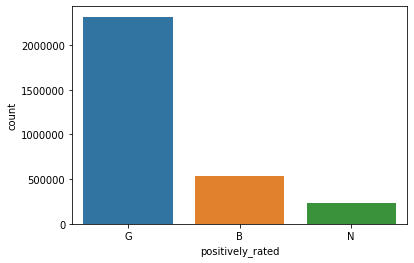

In [71]:
sns.countplot(sent_df['positively_rated'])

In [72]:
x_train, x_test, y_train, y_test = train_test_split(sent_df['review_body'], sent_df['positively_rated'], random_state = 50)

In [73]:
vect = TfidfVectorizer().fit(x_train)

In [ ]:
x_train_vectorized = vect.transform(x_train)
#model = LogisticRegression()
#model.fit(x_train_vectorized, y_train)

## PySpark

In [24]:
! pip install pyspark

In [25]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [26]:
electronics = spark.read.csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", sep = '\t')#.iloc[1:,:]
electronics.show(vertical=True)
toys = spark.read.csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Toys_v1_00.tsv.gz")

-RECORD 0--------------------
 _c0  | marketplace          
 _c1  | customer_id          
 _c2  | review_id            
 _c3  | product_id           
 _c4  | product_parent       
 _c5  | product_title        
 _c6  | product_category     
 _c7  | star_rating          
 _c8  | helpful_votes        
 _c9  | total_votes          
 _c10 | vine                 
 _c11 | verified_purchase    
 _c12 | review_headline      
 _c13 | review_body          
 _c14 | review_date          
-RECORD 1--------------------
 _c0  | US                   
 _c1  | 41409413             
 _c2  | R2MTG1GCZLR2DK       
 _c3  | B00428R89M           
 _c4  | 112201306            
 _c5  | yoomall 5M Antenn... 
 _c6  | Electronics          
 _c7  | 5                    
 _c8  | 0                    
 _c9  | 0                    
 _c10 | N                    
 _c11 | Y                    
 _c12 | Five Stars           
 _c13 | As described.        
 _c14 | 2015-08-31           
-RECORD 2--------------------
 _c0  | US

In [27]:
electronics.filter(electronics.marketplace.isNotNull()).show()

AttributeError: 'DataFrame' object has no attribute 'marketplace'

## Dask

In [ ]:
import dask as d
import dask.dataframe as dd
import dask.array as da

In [ ]:
electronics_dask = dd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", sep ='\t')